# Setup

In [59]:
import pandas as pd
import matplotlib.pyplot as plt # para visualização de informações
import seaborn as sns

In [14]:
import spacy
from spacy.lang.el.examples import sentences 

## K fold

In [15]:
from kfold import k_folds, train_values, test_values

## Models

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
from sklearn.pipeline import Pipeline

## Metrics

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## Text to list

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Reading and visualizing data

In [21]:
#Lembre de fazer upload dele nos arquivos do colab
PATH = "./data/iliad_sentiments.csv"

In [22]:
df = pd.read_csv(PATH)  
df

,greek text,english text,neutral,positive,negative,narrator,y,class
0,"Τη μάνητα, θεά, τραγούδα μας του ξακουστού Αχι...",Apollo’s priest to th’ Argive fleet doth bring,0.375,0.500,0.125,0.0,"[0.375, 0.5, 0.125, 0.0]",positive
1,"ανάθεμα τη, πίκρες που 'δωκε στους Αχαιούς περ...","Gifts for his daughter, pris’ner to the king;",0.125,0.250,0.625,0.0,"[0.125, 0.25, 0.625, 0.0]",negative
2,και πλήθος αντρειωμένες έστειλε ψυχές στον Άδη...,For which her tender’d freedom he entreats;,0.000,0.125,0.875,0.0,"[0.0, 0.125, 0.875, 0.0]",negative
3,"παλικαριών, στους σκύλους ρίχνοντας να φάνε τα...","But, being dismiss’d with contumelious threats,",0.000,0.125,0.875,0.0,"[0.0, 0.125, 0.875, 0.0]",negative
4,και στα όρνια ολούθε —έτσι το θέλησε να γίνει ...,"At Phœbus’ hands, by vengeful pray’r, he seeks",0.500,0.125,0.375,0.0,"[0.5, 0.125, 0.375, 0.0]",neutral
...,...,...,...,...,...,...,...,...
606,κει που 'χε χτίσει στον καθένα τους παλάτι ο κ...,"Address’d for sleep, where ev’ry one, with art...",0.375,0.625,0.000,0.0,"[0.375, 0.625, 0.0, 0.0]",positive
607,"ο ξακουστός τεχνίτης Ήφαιστος, με τη σοφή του ...",By heav’n’s great both-foot-halting God a sev’...,0.250,0.750,0.000,0.0,"[0.25, 0.75, 0.0, 0.0]",positive
608,"Κι ο Δίας ο Ολύμπιος, ό αστραπόχαρος, στην κλί...","Ev’n he to sleep went, by whose hand heav’n is...",0.250,0.750,0.000,0.0,"[0.25, 0.75, 0.0, 0.0]",positive
609,"εκεί που ως τώρα πάντα, ως του 'ρχονταν ύπνος ...","High Jove, where he had us’d to rest when swee...",0.125,0.875,0.000,0.0,"[0.125, 0.875, 0.0, 0.0]",positive


## Distribution

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   greek text    611 non-null    object 
 1   english text  611 non-null    object 
 2   neutral       611 non-null    float64
 3   positive      611 non-null    float64
 4   negative      611 non-null    float64
 5   narrator      611 non-null    float64
 6   y             611 non-null    object 
 7   class         611 non-null    object 
dtypes: float64(4), object(4)
memory usage: 38.3+ KB


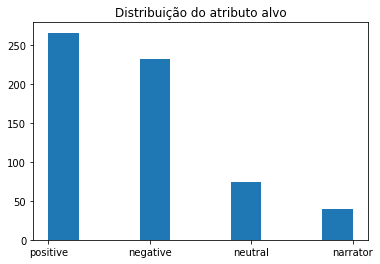

In [24]:
## Distribuição do atributo alvo
plt.hist(df['class'])
plt.title("Distribuição do atributo alvo")
plt.show()

## Ambiguous values

In [25]:
def count_values(nro_instances, df_inverse):
    counter = [df_inverse[i].value_counts() for i in range(0, nro_instances)] 

    return counter

def count_ambiguous(counter):
    nro_ambiguous = 0
    ambiguos_list = []
    
    for idx, count in enumerate(counter):
        indexes = count.index
        max_index = indexes.max()

        if count.at[max_index] > 1:
            nro_ambiguous += 1
            ambiguos_list.append(idx)

    return nro_ambiguous, ambiguos_list

def get_ambiguous(df):
    
    df_inverse = df.T
    df_inverse = df_inverse.drop(["greek text", "english text", "class", "y"])
    
    counter = count_values(len(df), df_inverse)
    
    nro_ambiguous, ambiguos_list = count_ambiguous(counter)
    
    return nro_ambiguous, ambiguos_list

In [26]:
nro_ambiguous, ambiguos_list = get_ambiguous(df)

In [27]:
nro_ambiguous

69

## Number of tokens

In [28]:
df_tokens = df.copy()
df_tokens['token_count'] = df["greek text"].str.replace(',','').str.split().str.len()
df_tokens.filter(['greek text','token_count'])

,greek text,token_count
0,"Τη μάνητα, θεά, τραγούδα μας του ξακουστού Αχι...",8
1,"ανάθεμα τη, πίκρες που 'δωκε στους Αχαιούς περ...",8
2,και πλήθος αντρειωμένες έστειλε ψυχές στον Άδη...,8
3,"παλικαριών, στους σκύλους ρίχνοντας να φάνε τα...",9
4,και στα όρνια ολούθε —έτσι το θέλησε να γίνει ...,12
...,...,...
606,κει που 'χε χτίσει στον καθένα τους παλάτι ο κ...,10
607,"ο ξακουστός τεχνίτης Ήφαιστος, με τη σοφή του ...",9
608,"Κι ο Δίας ο Ολύμπιος, ό αστραπόχαρος, στην κλί...",11
609,"εκεί που ως τώρα πάντα, ως του 'ρχονταν ύπνος ...",11


/tmp/ipykernel_17482/3560189687.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_tokens.token_count)


<Axes: xlabel='token_count', ylabel='Density'>

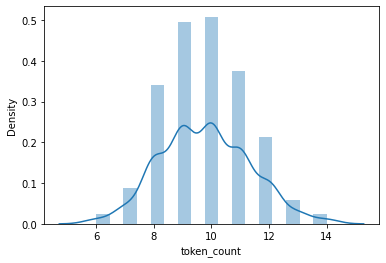

In [29]:
sns.distplot(df_tokens.token_count)

## Class and verses

In [30]:
df.index.name = "verse"

In [31]:
df = df.reset_index()

In [32]:
class_to_color_id = pd.factorize(df["class"])[0]

<Axes: xlabel='verse', ylabel='class'>

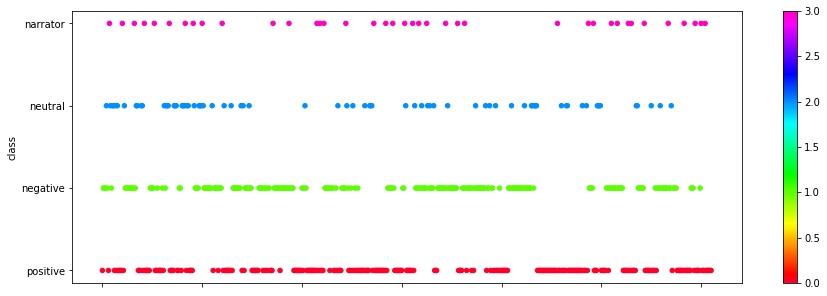

In [33]:
df.plot.scatter(x="verse", y='class', c=class_to_color_id, colormap="gist_rainbow", figsize=(15, 5))

# Pre processing

In [30]:
import numpy as np

**Lemmatization**

In [31]:
#!python -m spacy download el_core_news_md

In [262]:
def lemmatize_sentence(sentence):
    lemma_list = []
    
    nlp = spacy.load("el_core_news_md")
    doc = nlp(sentence)
    
    lemma_list= [token.lemma_ for token in doc if token.pos_ != "PUNCT"] 
    
    return " ".join(lemma_list)

**X & Y list**

In [32]:
X_temp = df["greek text"].tolist()

In [35]:
ohe = OneHotEncoder()
y_temp = ohe.fit_transform(df[['class']])

ohe.categories_

OneHotEncoder()

In [263]:
X = [lemmatize_sentence(x) for x in X_temp]
y = y_temp.toarray()

KeyboardInterrupt: 

In [266]:
y = y_temp.toarray()

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

# TF-IDF

**Spliting k folds**

In [ ]:
folds = k_folds(X=X, y=y, k=4, shuffle=True)

## Naive Bayes

In [ ]:
accuracy_list = []
recall_list = []
precision_list = []

#Cross validation
for (train_fold, test_fold) in folds:
    #Train and test
    X_train, y_train =  train_values(X, y, train_fold)
    X_test, y_test =  test_values(X, y, test_fold)
    
    #Naive Bayes
    text_nb = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
        ])

    text_nb.fit(X_train, y_train)
    predicted = text_nb.predict(X_test)

    accuracy = accuracy_score(y_test, predicted, normalize=False)
    recall = recall_score(y_test, predicted, average='macro') * 100
    precision = precision_score(y_test, predicted, average='macro') * 100
    
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)
    
nb_metrics = {}
    
nb_metrics["accuracy"] = np.average(accuracy_list) #np.std(accuracy_list)
nb_metrics["recall"] = np.average(recall_list)
nb_metrics["precision"] = np.average(precision_list)

print(nb_metrics)

## Decision Tree

In [ ]:
accuracy_list = []
recall_list = []
precision_list = []

#Cross validation
for (train_fold, test_fold) in folds:
    #Train and test
    X_train, y_train =  train_values(X, y, train_fold)
    X_test, y_test =  test_values(X, y, test_fold)
    
    text_tree = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier(max_depth=5,class_weight='balanced',random_state=42)),
    ])

    text_tree.fit(X_train, y_train)
    predicted = text_tree.predict(X_test)

    accuracy = accuracy_score(y_test, predicted, normalize=False)
    recall = recall_score(y_test, predicted, average='macro') * 100
    precision = precision_score(y_test, predicted, average='macro') * 100
    
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)

dt_metrics = {}
    
dt_metrics["accuracy"] = np.average(accuracy_list)
dt_metrics["recall"] = np.average(recall_list)
dt_metrics["precision"] = np.average(precision_list)

print(dt_metrics)

## KNN

In [ ]:
accuracy_list = []
recall_list = []
precision_list = []

#Cross validation
for (train_fold, test_fold) in folds:
    #Train and test
    X_train, y_train =  train_values(X, y, train_fold)
    X_test, y_test =  test_values(X, y, test_fold)
    
    text_knn = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', KNeighborsClassifier(n_neighbors=5)),
    ])

    text_knn.fit(X_train, y_train)
    predicted = text_knn.predict(X_test)

    accuracy = accuracy_score(y_test, predicted, normalize=False)
    recall = recall_score(y_test, predicted, average='macro') * 100
    precision = precision_score(y_test, predicted, average='macro') * 100
    
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)

knn_metrics = {}
    
knn_metrics["accuracy"] = np.average(accuracy_list)
knn_metrics["recall"] = np.average(recall_list)
knn_metrics["precision"] = np.average(precision_list)

print(knn_metrics)

# SBERT

In [19]:
#!pip install -U sentence-transformers

In [20]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('lighteternal/stsb-xlm-r-greek-transfer')

C:\Users\Katia\anaconda3\envs\illiad\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
X_train_sbert = model.encode(X_train)
X_test_sbert = model.encode(X_test)

## Decision Tree

In [23]:
accuracy_list = []
recall_list = []
precision_list = []

#Cross validation
for (train_fold, test_fold) in folds:
    #Train and test
    X_train, y_train =  train_values(X, y, train_fold)
    X_test, y_test =  test_values(X, y, test_fold)
    
    X_train_sbert = model.encode(X_train)
    X_test_sbert = model.encode(X_test)
    
    text_dt = DecisionTreeClassifier(max_depth=5,class_weight='balanced',random_state=42)
    text_dt.fit(X_train_sbert, y_train)
    predicted = text_dt.predict(X_test_sbert)

    accuracy = accuracy_score(y_test, predicted, normalize=False)
    recall = recall_score(y_test, predicted, average='macro') * 100
    precision = precision_score(y_test, predicted, average='macro') * 100
    
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)
    
dt_metrics = {}
    
dt_metrics["accuracy"] = np.average(accuracy_list)
dt_metrics["recall"] = np.average(recall_list)
dt_metrics["precision"] = np.average(precision_list)

print(dt_metrics)

{'accuracy': 55.25, 'recall': 34.04707097271422, 'precision': 32.966533811799266}


# CÓDIGOS DE EXEMPLO

### Functions to greek text

Não está funcionando

In [ ]:
!pip install cltk

In [ ]:
from cltk.stem.lemma import LemmaReplacer
#from cltk.corpus.utils.formatter import cltk_normalize

In [ ]:
from cltk.stem.lemma import LemmaReplacer
sentence = 'λόγων λογίων'
lemmatizer = LemmaReplacer('greek')
lemmatizer.lemmatize(sentence, return_raw=True)

## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

**Bag of Words**

In [ ]:
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.fit_transform(X_test)
X_train_counts.shape

**TF-IDF**

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_train_tfidf.shape

In [ ]:
def get_bow(X_train, X_test):
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train)
    X_test_counts = count_vect.fit_transform(X_test)
    
    return X_train_counts, X_test_counts

In [ ]:
def get_tfidf(X_train, X_test):
    X_train_counts, X_test_counts = get_bow(X_train, X_test)
    
    tfidf_transformer = TfidfTransformer()
    
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
    
    return X_train_tfidf, X_test_tfidf

### Testar com lematização e stemming

Sugestões que encontrei:
- https://legacy.cltk.org/en/latest/greek.html#lemmatization
- https://github.com/kpech21/Greek-Stemmer

# UMAP

Diminuir a dimensionalidade do SBERT

In [ ]:
!pip install umap-learn

In [ ]:
import umap

In [ ]:
X_umap_train = umap.UMAP().fit_transform(X_train_sbert)
X_umap_test = umap.UMAP().fit_transform(X_test_sbert)

# Naive Bayes

In [ ]:
#TF-IDF

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)

accuracy = accuracy_score(y_test, predicted, normalize=False)
recall = recall_score(y_test, predicted, average='macro') * 100
precision = precision_score(y_test, predicted, average='macro') * 100

print("==== TF-IDF ====")
print(f"Accuracy: {accuracy}%")
print(f"Recall: {recall}%")
print(f"Precision: {precision}%")

In [ ]:
#SBERT

text_clf = MultinomialNB()
text_clf.fit(X_train_sbert, y_train)
predicted = text_clf.predict(X_test_sbert)

accuracy = accuracy_score(y_test, predicted, normalize=False)
recall = recall_score(y_test, predicted, average='macro') * 100
precision = precision_score(y_test, predicted, average='macro') * 100

print("==== SBERT ====")
print(f"Accuracy: {accuracy}%")
print(f"Recall: {recall}%")
print(f"Precision: {precision}%")

In [ ]:
#SBERT > UMAP

text_clf = MultinomialNB()
text_clf.fit(X_umap_train, y_train)
predicted = text_clf.predict(X_umap_test)

accuracy = accuracy_score(y_test, predicted, normalize=False)
recall = recall_score(y_test, predicted, average='macro') * 100
precision = precision_score(y_test, predicted, average='macro') * 100

print("==== SBERT > UMAP ====")
print(f"Accuracy: {accuracy}%")
print(f"Recall: {recall}%")
print(f"Precision: {precision}%")

## Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
#TF-IDF

text_tree = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier(max_depth=5,class_weight='balanced',random_state=42)),
])

text_tree.fit(X_train, y_train)
predicted = text_tree.predict(X_test)

accuracy = accuracy_score(y_test, predicted, normalize=False)
recall = recall_score(y_test, predicted, average='macro') * 100
precision = precision_score(y_test, predicted, average='macro') * 100

print("==== TF-IDF ====")
print(f"Accuracy: {accuracy}%")
print(f"Recall: {recall}%")
print(f"Precision: {precision}%")

In [ ]:
#SBERT

text_tree = DecisionTreeClassifier(max_depth=5,class_weight='balanced',random_state=42)
text_tree.fit(X_train_sbert, y_train)
predicted = text_tree.predict(X_test_sbert)

accuracy = accuracy_score(y_test, predicted, normalize=False)
recall = recall_score(y_test, predicted, average='macro') * 100
precision = precision_score(y_test, predicted, average='macro') * 100

print("==== SBERT ====")
print(f"Accuracy: {accuracy}%")
print(f"Recall: {recall}%")
print(f"Precision: {precision}%")

In [ ]:
#SBERT > UMAP

text_tree = DecisionTreeClassifier(max_depth=5,class_weight='balanced',random_state=42)
text_tree.fit(X_umap_train, y_train)
predicted = text_tree.predict(X_umap_test)

accuracy = accuracy_score(y_test, predicted, normalize=False)
recall = recall_score(y_test, predicted, average='macro') * 100
precision = precision_score(y_test, predicted, average='macro') * 100

print("==== SBERT > UMAP ====")
print(f"Accuracy: {accuracy}%")
print(f"Recall: {recall}%")
print(f"Precision: {precision}%")

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
text_knn = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=5)),
])

text_knn.fit(X_train, y_train)
predicted = text_knn.predict(X_test)

accuracy = accuracy_score(y_test, predicted, normalize=False)
recall = recall_score(y_test, predicted, average='macro') * 100
precision = precision_score(y_test, predicted, average='macro') * 100

print("==== TF-IDF ====")
print(f"Accuracy: {accuracy}%")
print(f"Recall: {recall}%")
print(f"Precision: {precision}%")

Normalizar e diminuir a dimensionalidade

In [ ]:
#SBERT

text_knn = KNeighborsClassifier(n_neighbors=5)
text_knn.fit(X_train_sbert, y_train)
predicted = text_knn.predict(X_test_sbert)

accuracy = accuracy_score(y_test, predicted, normalize=False)
recall = recall_score(y_test, predicted, average='macro') * 100
precision = precision_score(y_test, predicted, average='macro') * 100

print("==== SBERT ====")
print(f"Accuracy: {accuracy}%")
print(f"Recall: {recall}%")
print(f"Precision: {precision}%")

In [ ]:
#SBERT > UMAP

text_knn = KNeighborsClassifier(n_neighbors=5)
text_knn.fit(X_umap_train, y_train)
predicted = text_knn.predict(X_umap_test)

accuracy = accuracy_score(y_test, predicted, normalize=False)
recall = recall_score(y_test, predicted, average='macro') * 100
precision = precision_score(y_test, predicted, average='macro') * 100

print("==== SBERT > UMAP ====")
print(f"Accuracy: {accuracy}%")
print(f"Recall: {recall}%")
print(f"Precision: {precision}%")

# Matrix de confusão

In [60]:
def confusion_matrix(y_true, y_pred, categories):
    # Build matrix
    categories = list(categories[0])
    matrix = [[]] * len(categories)
    for i in range(len(categories)):
        matrix[i] = [0] * len(categories)
    
    # Calculate matirx
    for i in range(len(y_true)):
        matrix[categories.index(y_true[i])][categories.index(y_pred[i])] += 1

    return matrix

In [61]:
def plot_confusion_matrix(confusion_matrix, categories):
    df_cm = pd.DataFrame(confusion_matrix, index = [i for i in categories], columns = [i for i in categories])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)

[[1, 0, 0, 0], [0, 5, 0, 1], [0, 0, 1, 0], [0, 0, 0, 5]]


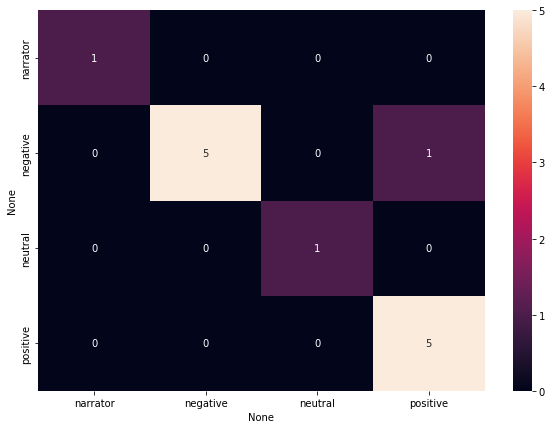

In [62]:
# Exemplo de uso
truest_y = ["negative", "negative", "negative", "negative", "positive", "neutral", "negative", "negative", "narrator", "positive", "positive", "positive", "positive"]
fake_y = ["positive", "negative", "negative", "negative", "positive", "neutral", "negative", "negative", "narrator", "positive", "positive", "positive", "positive"]

cm_test = confusion_matrix(truest_y, fake_y, ohe.categories_)
print(cm_test)

plot_confusion_matrix(cm_test, ohe.categories_)